In [151]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

This notebook was built with:
python version: 3.9.19 (main, Apr  6 2024, 17:57:55) 
[GCC 9.4.0]
PCSE version: 5.5.6


In [152]:
true_params = {}
true_params["TDWI"] = 160
true_params["WAV"] = 5
true_params["SPAN"] = 33
true_params["SMFCF"] = .33

p = copy.deepcopy(parameters)
for par, distr in true_params.items():
    p.set_override(par, distr)
ground_truth = Wofost72_WLP_FD(p, weather, agromanagement)
ground_truth.run_till_terminate()

output_df = pd.DataFrame(ground_truth.get_output())
obs = output_df["LAI"].values
output_df

,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
0,2000-01-01,0.000000,0.110240,80.000000,0.000000,52.000000,28.000000,80.000000,0.004429,10.0,0.250000,14.090000
1,2000-01-02,0.008867,0.117624,85.358251,0.000000,55.482863,29.875388,85.358251,0.002547,11.2,0.244819,14.053816
2,2000-01-03,0.017157,0.125290,90.921918,0.000000,59.099247,31.822671,90.921918,0.001995,12.4,0.242331,14.038579
3,2000-01-04,0.024293,0.133008,96.522179,0.000000,62.739416,33.782763,96.522179,0.004869,13.6,0.240616,14.027895
4,2000-01-05,0.032706,0.141716,102.841829,0.000000,66.847189,35.994640,102.841829,0.002797,14.8,0.238408,14.005806
...,...,...,...,...,...,...,...,...,...,...,...,...
147,2000-05-27,1.934169,0.003116,12332.320594,6649.452325,2486.526710,3196.341558,1267.657506,0.000822,60.0,0.240065,14.403914
148,2000-05-28,1.953874,0.003116,12332.320594,6649.452325,2486.526710,3196.341558,1267.657506,0.000826,60.0,0.237451,14.247070
149,2000-05-29,1.974056,0.000000,12332.320594,6649.452325,2486.526710,3196.341558,1267.657506,0.000000,60.0,0.235169,14.110155
150,2000-05-30,1.995758,0.000000,12332.320594,6649.452325,2486.526710,3196.341558,1267.657506,0.000000,60.0,0.232671,13.960288


In [153]:
import itertools

import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)
rng = np.random.default_rng(12345)

import matplotlib.pyplot as plt

COLORS = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams.update({"font.size": 10})

import iterative_ensemble_smoother as ies

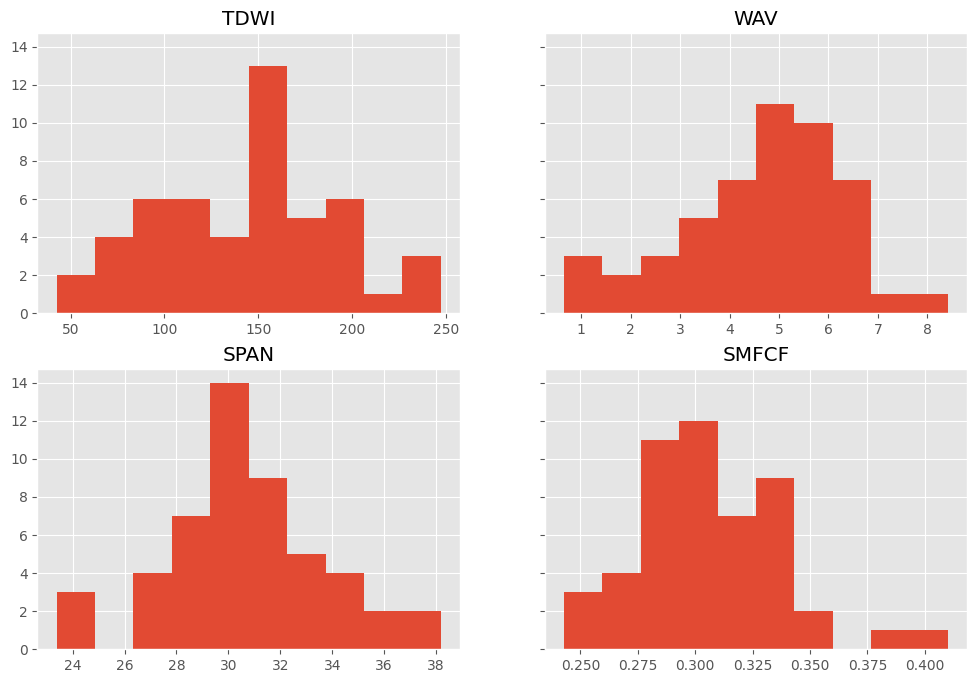

In [154]:
ensemble_size = 50
np.random.seed(10000)

# A container for the parameters that we will override
override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

In [155]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

for member in ensemble:
    member.run_till_terminate()

In [156]:
results = [pd.DataFrame(member.get_output()).set_index("day") for member in ensemble]
lais = np.array([
    result["LAI"].values
    for result in results
]).T

In [157]:
params = np.array([
    distr
    for distr in override_parameters.values()
])

In [158]:
from iterative_ensemble_smoother.utils import steplength_exponential

X_IES_ert = params.copy()
Y_IES_ert = lais.copy()

smoother_ies = ies.SIES(
    parameters = X_IES_ert,
    covariance = np.eye(obs.shape[0]) ,
    observations = obs,
    seed=42,
)

n_ies_iter = 10
for i in range(n_ies_iter):
    step_length = steplength_exponential(i + 1)
    X_IES_ert = smoother_ies.sies_iteration(Y_IES_ert, step_length=step_length)

    IES_ensemble = []
    for j in range(X_IES_ert.shape[1]):
        p = copy.deepcopy(parameters)
        for k, par in enumerate(override_parameters.keys()):
            p.set_override(par, X_IES_ert[k, j])
        IES_member = Wofost72_WLP_FD(p, weather, agromanagement)
        IES_member.run_till_terminate()
        IES_ensemble.append(IES_member)

    Y_IES_ert_dfs = [pd.DataFrame(member.get_output()).set_index("day") for member in IES_ensemble]
    Y_IES_ert = np.array([
        Y_IES_ert_df["LAI"].values
        for Y_IES_ert_df in Y_IES_ert_dfs
    ]).T

array([<Axes: title={'center': 'TDWI'}>, <Axes: title={'center': 'WAV'}>,
       <Axes: title={'center': 'SPAN'}>,
       <Axes: title={'center': 'SMFCF'}>], dtype=object)

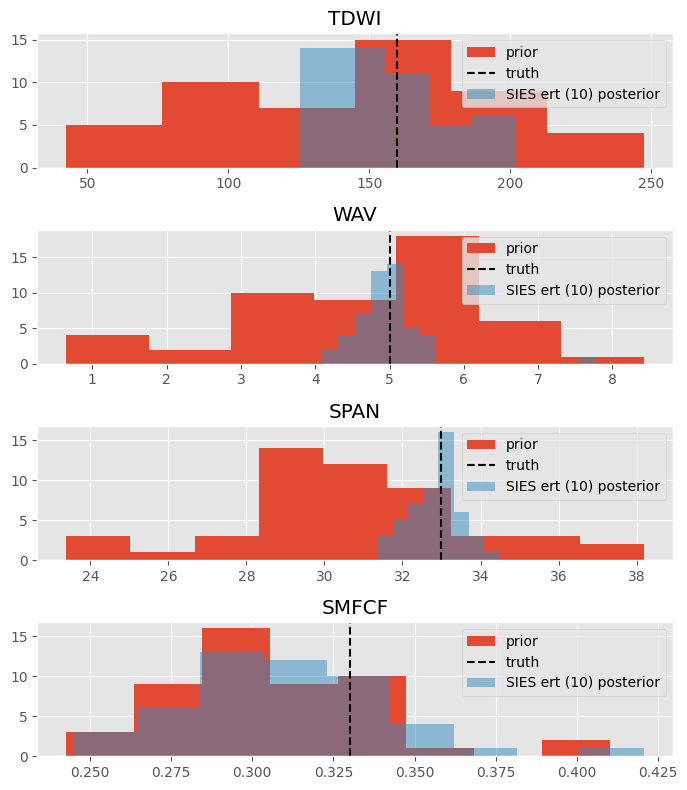

In [159]:
def plot_posterior(ax, posterior, method):
    for i, param in enumerate(override_parameters.keys()):
        ax[i].set_title(param)
        ax[i].hist(posterior[i, :], label=f"{method} posterior", alpha=0.5, bins="fd")
        ax[i].legend()

    fig.tight_layout()
    return ax


fig, ax = plt.subplots(nrows=4, figsize=(7, 8))

for i, p in enumerate(override_parameters.keys()):
    ax[i].hist(override_parameters[p], label="prior", bins="fd")

ax[0].axvline(true_params["TDWI"], color="k", linestyle="--", label="truth")
ax[1].axvline(true_params["WAV"], color="k", linestyle="--", label="truth")
ax[2].axvline(true_params["SPAN"], color="k", linestyle="--", label="truth")
ax[3].axvline(true_params["SMFCF"] , color="k", linestyle="--", label="truth")

plot_posterior(ax, X_IES_ert, method=f"SIES ert ({n_ies_iter})")